In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline

# Petite classe n. 1 
## Time Series Simulation & Analysis
### ECO586 - Phenomenology and modelling of financial markets
### Michael Benzaquen, José Moran


Through the course and exercise sessions you are expected to encounter and analyse numerical time series from financial data. The goal of this session is to familarize you with the numerical analysis of time series, as well as to give you some basic intuition on what can cause the emergence of some stylized facts in financial time series.


## I. Fractional Brownian motion

A fractional brownian motion is a stochastic process that has the property that

$$
\langle x_H(t)x_H(s) \rangle = \frac{1}{2}(\vert t \vert^{2H} + \vert s \vert^{2H} - \vert t - s \vert^{2H})
,\quad t,s>1$$.


The parameter $H$ is called the Hurst exponent and controls the "roughness" of the process. $H=1/2$ corresponds to standard brownian motion. For $H<1/2$ the process is "rougher" than standard brownian motion and the increments are anti-correlated (mean-reversion). For $H>1/2$ the process is "smoother", with trending increments. 


1. Let $L$ be a $T\times T$ matrix. Show that the correlation matrix of the vector $Y = LX$, where $X$ is an iid. gaussian vector of size $T$, is given by $C= L^tL$.

2. Define a function `C(i,j,H)` giving the $C_{ij}$ term of the correlation matrix of an fBM with exponent H. Using the function `np.fromfunction()` compute the matrix for an fBM of length T=1000 and the exponent of your choice. Use the Cholesky decomposition with `np.linalg.cholesky` to generate a fractional brownian motion, rescaled as 

$$
\tilde{x}_H(t) = 1 / T^H x_H(t)
$$
so that all simulated curves have roughly the same scale.

In [3]:
def correlation(i,j, H):
    return 1/2 * (np.abs(1+i)**(2*H) +np.abs(1+j)**(2*H)-np.abs(i-j)**(2*H))

T = 1000

c_mat = np.fromfunction(lambda i,j: correlation(i,j, H=0.33), shape = (T,T))
L = np.linalg.cholesky(c_mat)
xi = np.random.randn(T)
xib = np.dot(L,xi)

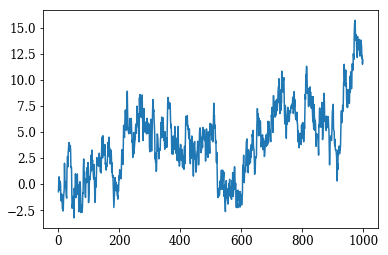

In [4]:
plt.plot(xib)

3. Group everything into a function `gen_fbm(T,H)` that returns an instance of a (rescaled) fBM with exponent $H$. Plot for $H=0.25,0.5,0.75$. Comments ? 

In [5]:
def gen_fbm(T,H):
    c_mat = np.fromfunction(lambda i,j: correlation(i,j, H=H), shape = (T,T))
    L = np.linalg.cholesky(c_mat)
    xi = np.random.randn(T)
    xib = np.dot(L,xi)
    return xib / (T ** H)

x1 = gen_fbm(T, 0.25)
x2 = gen_fbm(T, 0.5)
x3 = gen_fbm(T, 0.75)

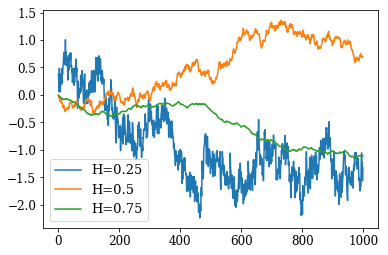

In [6]:
plt.plot(x1, label='H=0.25')
plt.plot(x2, label= 'H=0.5')
plt.plot(x3, label='H=0.75')
plt.legend()

3. To generate statistics over the fBM process it is necessary to generate many instances of it. Define now a function `gen_N_fbm(T,N,H)` that returns a $T\times N$ array with N instances of the fractional brownian motion for the same exponent $H$. Hint : what happens if we take the vector $X$ to be gaussian iid matrix of size $T\times N$ ? 

In [7]:
def gen_N_fbm(T,N,H):
    c_mat = np.fromfunction(lambda i,j: correlation(i,j, H=H), shape = (T,T))
    L = np.linalg.cholesky(c_mat)
    xi = np.random.randn(T,N)
    xib = np.dot(L,xi)
    return xib / (T ** H)

In [8]:
x = gen_N_fbm(1000,2,0.25)

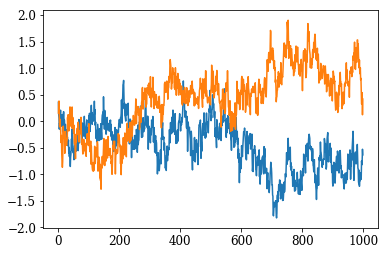

In [9]:
plt.plot(x)

4. Create a DataFrame with 100 columns, each containing a realisation of the fBM with $H=0.3$ and $T=1000$. 


6. Create a function that computes the value $(x(t)-x(t+\tau))^2$, averages it over $t$ for a given realization, and then averages over all of th realisations in `df` for a single value $\tau$. 

Use it to compute the variogram, 
$$
V(\tau) = \langle (x(t+\tau)-x(t))^2\rangle.
$$ 
on a set of points,
* Plot it alongside the theoretical value, for $1\leq \tau \leq 500$ on log-log scale. 
* Do the same with $H=0.75$, and compute its variogram. Plot the volatility signature plots, $s(\tau)=v(\tau)/\tau$ on normal scaling for both exponents and compare.

In [10]:
df1 = pd.DataFrame(gen_N_fbm(1000,100,0.3))

In [33]:
df2 = pd.DataFrame(gen_N_fbm(1000,100,0.75))

In [34]:
def variogram(df, taus):
    v =  np.vectorize(lambda tau: (((df - df.shift(tau))**2).mean()).mean())
    return v(taus)

taus = np.linspace(0,500, dtype=int, num = 500)

v1 = variogram(df1, taus)
v2 = variogram(df2, taus)

In [35]:
len(taus)

500

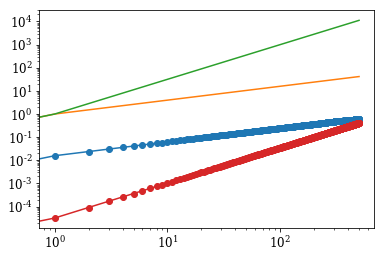

In [39]:
plt.plot(taus,v1, '-o')
plt.plot(taus, taus ** 0.6)
plt.plot(taus, taus **(1.5))
plt.plot(taus,v2,'-o')
plt.yscale('log')
plt.xscale('log')

## II. The Ornstein-Uhlenbeck process

The Ornstein-Uhlenbeck process (centered around $0$) is defined by the following SDE:

$$
\frac{\mathrm{d}x}{\mathrm{d}t} = - \gamma x + \sigma \xi(t),\quad \langle \xi(t)\xi(t')\rangle = \delta(t-t').
$$

We remind that the discretization according to the Itô prescription of this SDE is given by:

$$
x_{(N+1)\Delta t} = x_{N\Delta t}(1-\gamma \Delta t) + \sigma \sqrt{\Delta t} \xi_{N} 
$$
where the $(\xi_N)$ variables are normally distributed with variance $1$. 

1. Write a function `ornstein_uhlenbeck(x_0, sigma, gamma, dt, T)` that returns a realisation of the Ornstein-Uhlenbeck process with initial condition $x_0$ and with parameters $\sigma$ and $\gamma$ over `T` steps with a discretization $dt$.  

In [40]:
def ornstein_uhlenbeck(x_0, sigma, gamma,dt, T):
    x = np.empty(T)
    xi = np.random.randn(T-1)
    x[0] = x_0
    for t in range(1,T):
        x[t] = (1-gamma * dt)*x[t-1] + sigma * np.sqrt(dt) * xi[t-1]
    return x

In [57]:
x1 = ornstein_uhlenbeck(0, sigma = 1, gamma = 4, dt = 1e-3, T = int(1e4))
x2 = ornstein_uhlenbeck(0, sigma = 1, gamma = 0.25, dt = 1e-3, T = int(1e4))

t = np.linspace(0, 1e4*1e-3, 1e4)

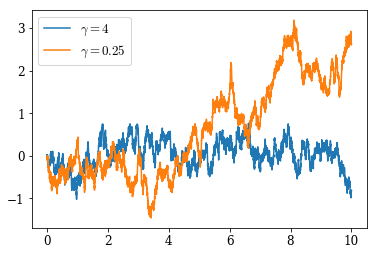

In [58]:
plt.plot(t,x1, label=r'$\gamma=4$')
plt.plot(t,x2, label=r'$\gamma=0.25$')
plt.legend()

3. To generate statistics over the Ornstein-Uhlenbeck process it is necessary to generate many instances of it. Write a new function `N_Ornstein_uhlenbeck(x_0, sigma, mu, dt, N, T)` that generates a $T\times N$ array where each column is a realisation of the O-U process with corresponding parameters. The $x_0$ initial condition is now a vector of size $N$. We remind that `a[i,:]` accesses the i-th row of array `a`, and `a[:,j]` its j-th column. 

Simulate with $N=2$ and plot the results to check. The two lines should be similar.

In [59]:
def N_Ornstein_uhlenbeck(x_0, sigma, gamma,dt,N, T):
    x = np.empty((T,N))
    xi = np.random.randn(T-1,N)
    x[0,:] = x_0
    for t in range(1,T):
        x[t,:] = (1-gamma * dt)*x[t-1,:] + sigma * np.sqrt(dt) * xi[t-1,:]
    return x

In [60]:
x1 = N_Ornstein_uhlenbeck(0, sigma = 1, gamma = 4, dt = 1e-3, N=2, T = int(1e4))

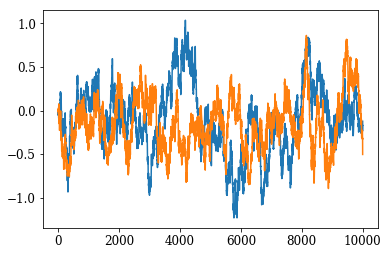

In [61]:
plt.plot(x1)

4. Show that the solution of the Ornstein-Uhlenbeck process is given by

$$
x(t) = x(0)e^{-\gamma t} + \sigma \int_{0}^t \mathrm{d} s~ e^{-\gamma(t-s)}\xi(s).
$$

(hint: integrate the SDE as a standard ODE)

Show that $\langle x(t)\rangle\underset{t\to\infty}{\longrightarrow}0$.

Take now $x(0)=0$ for simplicity. Compute the product $x(t)x(t+\tau)$ and average it over $\xi$, obtaining the correlation function:

$$
C(t,\tau) =  \frac{\sigma^2}{2\gamma}\left(e^{-\gamma \vert \tau \vert} - e^{-\gamma(2t+\tau)}\right)
$$

For long times, we therefore have $C(t,\tau)\underset{t\gg 1/\gamma}{\longrightarrow}  \frac{\sigma^2}{2\gamma}e^{-\gamma \vert \tau \vert}$

5. Create a DataFrame `df` where each row is a time point and with 100 columns corresponding to an instance of an Ornstein-Uhlenbeck process with $\sigma=1$ and your choice of $\gamma$. (hint: use `pd.DataFrame` on the output of a function you have defined). Take again $T=10^5$ and $dt=10^{-3}$.




In [62]:
x1 = N_Ornstein_uhlenbeck(0, sigma = 1, gamma = 4, dt = 1e-3, N=100, T = int(1e5))
df = pd.DataFrame(x1)

In [63]:
df.head(5)

0         1         2         3         4         5         6   \
0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1  0.022200 -0.046589 -0.024950  0.029184 -0.029307 -0.009325  0.018139   
2  0.027341 -0.064940 -0.014086  0.070163 -0.060008 -0.027817 -0.029772   
3  0.029583 -0.084225 -0.025946  0.102217 -0.018168 -0.027768 -0.039530   
4 -0.005777 -0.031396 -0.040226  0.163626 -0.012884 -0.023128 -0.058084   

         7         8         9   ...        90        91        92        93  \
0  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.000000   
1  0.028271  0.049924 -0.011143  ... -0.035247 -0.002536  0.049515  0.018960   
2 -0.014603  0.129028 -0.011171  ... -0.062360 -0.013005  0.059500 -0.018725   
3 -0.004335  0.112143 -0.027877  ... -0.053831 -0.034184  0.087765 -0.023324   
4 -0.045659  0.074219 -0.028979  ... -0.084733 -0.010913  0.061755  0.031876   

         94        95        96        97        98        99  
0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
1  0.007099  0.021160 -0.006679 -0.015493 -0.048986  0.003284  
2 -0.032222 -0.039008 -0.036722 -0.049445 -0.066851  0.046344  
3 -0.046769 -0.117537  0.007056 -0.022991 -0.095313  0.023153  
4 -0.073413 -0.095227  0.011514  0.006597 -0.102001  0.041639  

[5 rows x 100 columns]



6. Create a function that computes the correlation $x(t)x(t+\tau dt)$, averages it over $t$ for a given realisation, and then averages over all the realisations in `df` for a single value $\tau$.


In [64]:
def correlation_fct(df, taus):
    corr =  np.vectorize(lambda T: ((df * df.shift(T)).mean()).mean())
    return corr(taus)

Compute this correlation function over a set of points (at least up to $\tau dt = 2$) and compare this with $\sigma/(2\gamma)e^{-\gamma dt\tau}$.

(1e-05, 1.0)

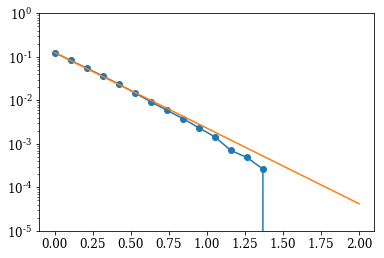

In [65]:
taus = np.linspace(0,2000, num = 20, dtype='int')

C = correlation_fct(df, taus)
plt.plot(taus*1e-3, C, '-o')
plt.plot(taus*1e-3, 1/8*np.exp(-4*taus*1e-3))
plt.yscale('log')
plt.ylim(1e-5,1e0)


7. Compute the variogram $V(\tau)$ of the Ornstein-Uhlenbeck process, as well as the volatility signature plot $V(\tau)/\tau$. Compare it to the fBM. What do you notice ? (Be smart, you already have the correlation function)!

### III. A physical example: turbulent flow

We simulate a physical chaotic system using the Lorenz attractor, an idealized model of a fluid with coordinates $(x,y,z)$, where $x$ is the convective intensity, $y$ the temperature difference between descending and ascending currents and $z$ the difference in vertical temperature profile. 

This evolution is given by

$$
\dot{x} = \sigma (y-x)\\
\dot{y} = rx - y - xz\\
\dot{z} = xy - bz
$$

we'll simulate this through $10^6$ time steps under a discretisation $dt=10^{-2}$.


In [ ]:
def lorenz(x, y, z, sigma=10, r=28, b=8/3):
    x_dot = sigma*(y - x)
    y_dot = r*x - y - x*z
    z_dot = x*y - b*z
    return x_dot, y_dot, z_dot


from mpl_toolkits.mplot3d import Axes3D


dt = 0.01
stepCnt = int(1e7)
T = np.linspace(0, stepCnt*dt, stepCnt+1)
# Need one more for the initial values
xs = np.empty((stepCnt + 1,))
ys = np.empty((stepCnt + 1,))
zs = np.empty((stepCnt + 1,))

# Setting initial values
xs[0], ys[0], zs[0] = (0., 1., 1.05)

# Stepping through "time".
for i in range(stepCnt):
    # Derivatives of the X, Y, Z state
    x_dot, y_dot, z_dot = lorenz(xs[i], ys[i], zs[i])
    xs[i + 1] = xs[i] + (x_dot * dt)
    ys[i + 1] = ys[i] + (y_dot * dt)
    zs[i + 1] = zs[i] + (z_dot * dt)

fig = plt.figure()
ax = fig.gca(projection='3d')

ax.plot(xs[:10000], ys[:10000], zs[:10000], lw=0.5)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor")

plt.show()

The system jumps between two attractors. 
Let's look at the evolution of the $z$ variable. 

In [ ]:
plt.plot(T[:10000]*dt, zs[:10000])

We will interpret this as a velocity.
Since we are interested in statistical properties, it is better to detrend and rescale this variable. 
We then define a variable $Z_t = \sum_{l=0}^t z_t$

In [ ]:
zs_ = (zs-np.mean(zs)) / np.std(zs)

Z = np.cumsum(zs_)

We can look at the evolution of this variable,

In [ ]:
plt.plot(T,np.cumsum(zs_))
plt.xlabel('Time t')
plt.ylabel('$Z_t$', fontsize=16)

1. Create a dataframe `df` containing a column for $Z_t$ called `Z`. Compute the variogram of $Z_t$, for $\tau$ in `np.logspace(0,6,20)`. What do you see ? 

2. Plot the histogram of $$\frac{x(t)-x(t+\tau)}{\sigma(\tau)}$$ where $$\sigma(\tau):=\sqrt{V(\tau)}=\sqrt{\langle (x(t+\tau)-x(t))^2 \rangle} $$in the same plot for different values of $\tau$. What do you notice ? 